In [1]:
import re
import string
from collections import Counter

import nltk
import pandas as pd
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import PunktSentenceTokenizer
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

## load Text of Book - Remove head and tail of Text

In [2]:
fname = "./Data/War_and_Peace_Book_One.txt"
with open(fname) as f:
    content = f.readlines()

In [3]:
if "About this digital edition\n" in content:
    content = content[:content.index("About this digital edition\n")]
if "CHAPTER I\n" in content:
    content = content[content.index("CHAPTER I\n"):]

## Preprocess of Data

In [4]:
def remove_hiddensymbols(content):
    content = list(filter(lambda a: a != '\n', content))
    text = " ".join(content).lower()
    text, _ = re.subn('\s+', ' ', text)
    text = text.strip()
    return text


def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text


stop_words = set(stopwords.words('english'))
stop_words.update(
    ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'may', 'also', 'across',
     'among', 'beside', 'however', 'yet', 'within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence


wordnet_lemmatizer = WordNetLemmatizer()
def lemmatizing(sentence):
    lemmSentence = ""
    for word in sentence.split():
        lemm = wordnet_lemmatizer.lemmatize(word, 'v')
        lemmSentence += lemm
        lemmSentence += " "
    lemmSentence = lemmSentence.strip()
    return lemmSentence


def preprocess_wrapper(text, hiddesymbol=True, Puntuationfilter=False, stopworkfilter=False, stemfilter=False,
                       lemafilter=True, sent_token=True):
    lemtext= ""
    #remove hidden symbols
    if hiddesymbol:
        text = remove_hiddensymbols(text)
        
    # remove puntuations
    if Puntuationfilter:
        text = text.translate(str.maketrans('', '', string.punctuation))
        
    # remove stop words
    if stopworkfilter:
        text = removeStopWords(text)
        
    # apply stemming
    if stemfilter:
        text = stemming(text)
    
    # apply lemmatizer
    if lemafilter:
        lemtext = lemmatizing(text)
        text=lemtext
    
    # apply tokenizer
    if sent_token:
        text = nltk.sent_tokenize(lemtext) 
    
    return text , lemtext

In [5]:
text,lemtext=preprocess_wrapper(content)

In [6]:
# generate list of list - list of sentence (each sentence is tokenized)
pos_ls=[]
for sent in text:
    for pos_item in nltk.pos_tag(nltk.word_tokenize(sent)):
        pos_ls.append(pos_item)

## Pos taging

In [7]:
Pos_token_df=pd.DataFrame(pos_ls)
Pos_token_df.columns=["token","POS"]
# apply pos tagging
tagmap = nltk.tag.mapping.tagset_mapping("en-ptb", "universal")
# generate more general tags
Pos_token_df["General_pos"]=Pos_token_df["POS"].apply(lambda x:tagmap[x])
Pos_token_df=Pos_token_df[Pos_token_df["General_pos"]!='.']
Pos_token_df["token_POS_gen"]=Pos_token_df.apply(lambda x:(x["token"],x["General_pos"]),axis=1)

### Count each token and thier POS tag

In [8]:
wordcount =Counter(list(Pos_token_df["token_POS_gen"]))
word_count=pd.DataFrame(list(wordcount.items()))
word_count.columns=["pairs","count"]
word_count.sort_values("count",inplace=True,ascending=False)
word_count.reset_index(drop=True,inplace=True)
word_count["token"]=word_count["pairs"].apply(lambda x:x[0])
word_count["pos"]=word_count["pairs"].apply(lambda x:x[1])
# remove stop word from list
word_count["stw"]=word_count["token"].apply(lambda x: x in list(stop_words))
word_count=word_count[word_count["stw"]==False]

## Generate Diagrams

### Generate Worldcloud of frequent words in whole text

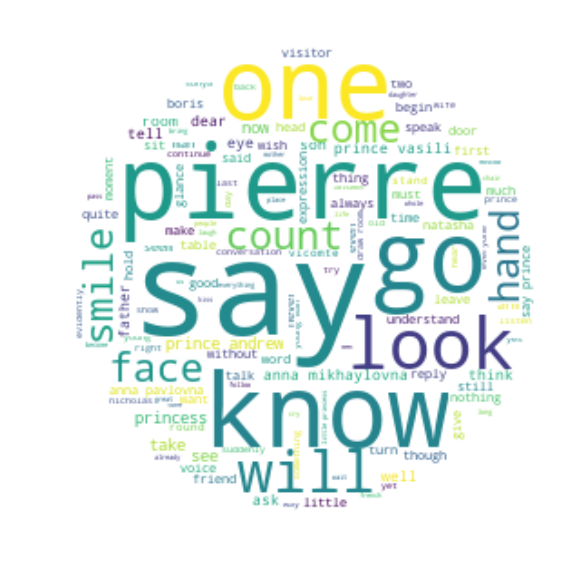

In [9]:
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)
wc = WordCloud(width=5000, height=800,background_color="white", repeat=True, mask=mask)
wc.generate(lemtext)
plt.figure( figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Disturbiution of Top 10 frequent Verb in whole text

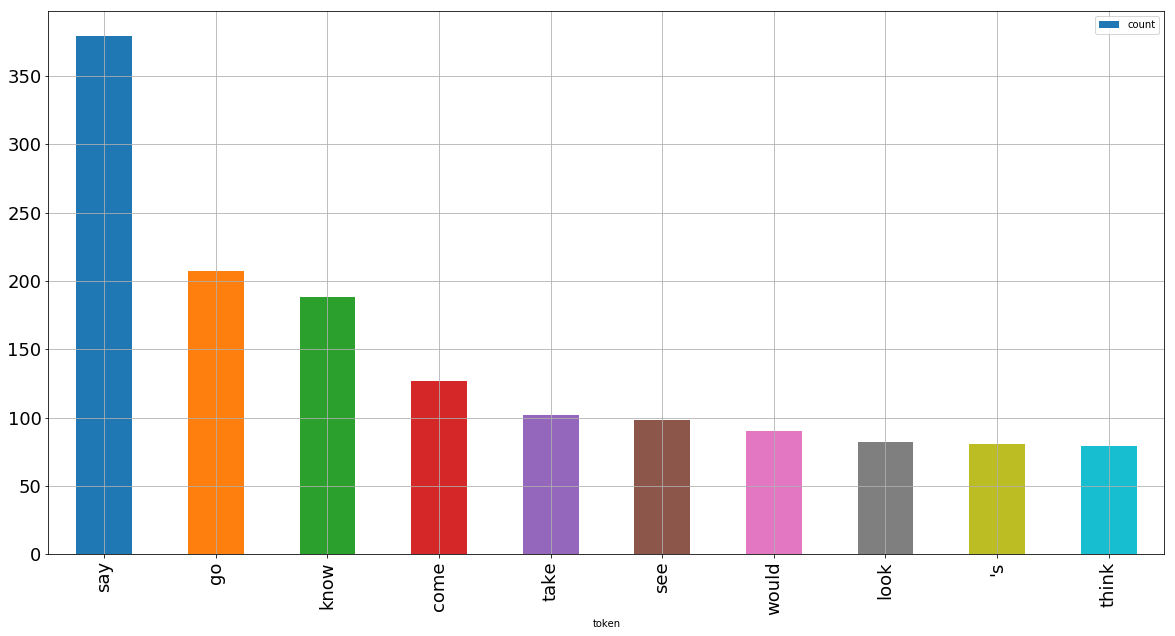

In [10]:
word_count[word_count["pos"]=="VERB"].head(10).plot(x="token", y="count",kind='bar',figsize=(20,10),fontsize=18,grid=True)

In [11]:
word_count[word_count["pos"]=="VERB"].head(10)[["token","count"]].reset_index(drop=True)

,token,count
0,say,379
1,go,207
2,know,188
3,come,127
4,take,102
5,see,98
6,would,90
7,look,82
8,'s,81
9,think,79


In [12]:
word_count[word_count["pos"]=="NOUN"].head(10)[["token","count"]]

,token,count
26,prince,299
36,count,183
39,pierre,169
40,princess,167
49,room,141
50,man,140
54,face,121
68,look,96
70,smile,93
72,vasili,92


In [13]:
word_count[word_count["pos"]=="ADJ"].head(10)[["token","count"]]

,token,count
67,little,96
77,young,86
87,old,77
106,anna,59
126,pierre,51
128,dear,50
159,last,41
185,great,34
191,much,33
198,good,32


In [14]:
word_count[word_count["pos"]=="ADV"].head(10)[["token","count"]]

,token,count
44,n't,152
75,well,89
103,still,62
116,even,55
117,always,55
142,never,46
160,suddenly,41
163,quite,40
170,evidently,37
201,already,32


In [15]:
verbs_set=set(word_count[word_count["pos"]=="VERB"].head(10)["token"])

### Disturbiution of Top 10 frequent Noun in whole text

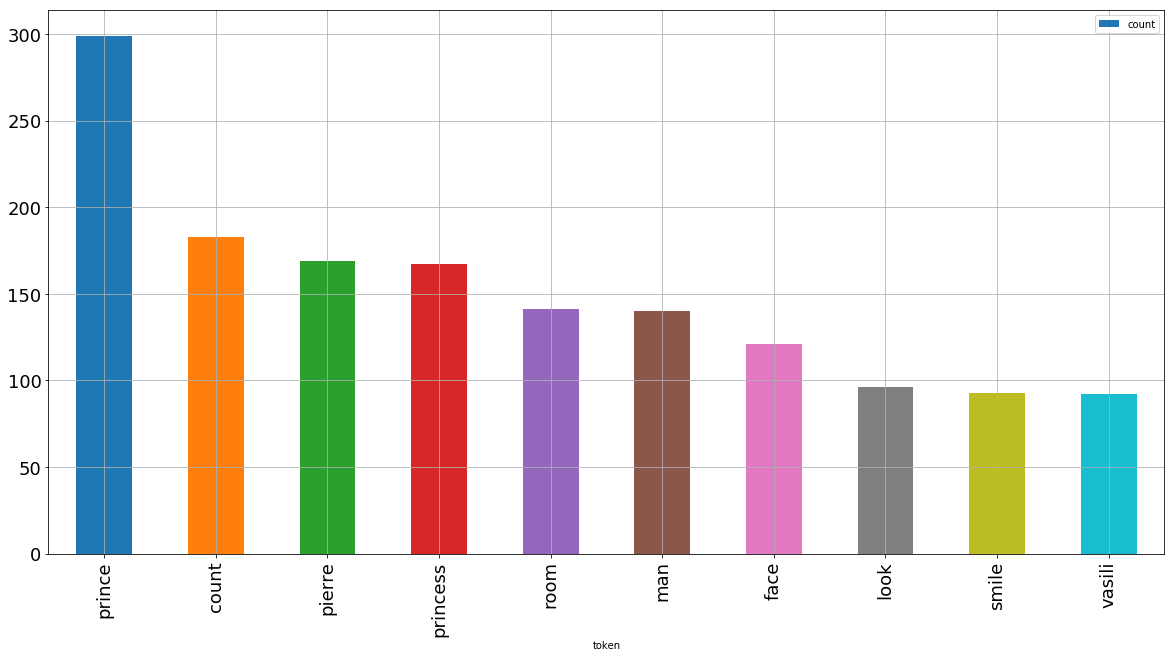

In [16]:
word_count[word_count["pos"]=='NOUN'].head(10).plot(x="token", y="count",kind='bar',figsize=(20,10),fontsize=18,grid=True)

In [17]:
NOUNs_set=set(word_count[word_count["pos"]=="NOUN"].head(10)["token"])

### Disturbiution of Top 10 frequent adj in whole text

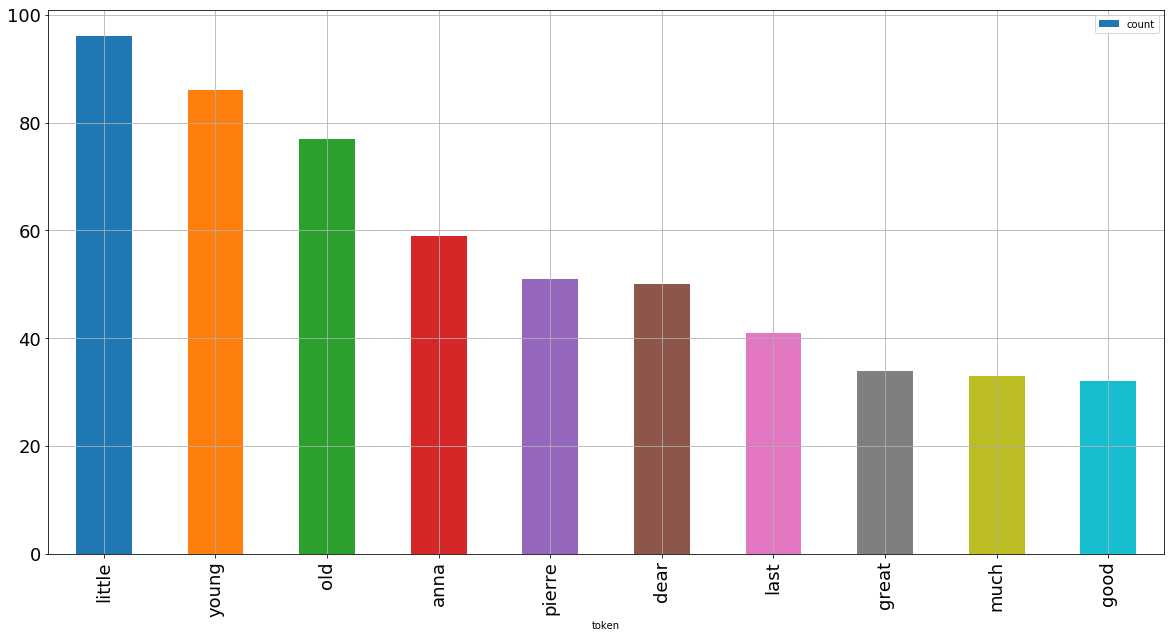

In [18]:
word_count[word_count["pos"]=='ADJ'].head(10).plot(x="token", y="count",kind='bar',figsize=(20,10),fontsize=18,grid=True)

In [19]:
ADJ_set=set(word_count[word_count["pos"]=="ADJ"].head(10)["token"])

## Split Sentences of the Document into 10 Groups Based on Progress of Text

### Accumulated split

In [20]:

nr=10
step=int(len(text)/nr)
parts=[]
for ix in range(0,10):
    start=ix*step
    end=(ix+1)*step
    if ix==9:
        parts.append(text[:-1])
    else:
        parts.append(text[:end])

### Seprated split

In [21]:
parts_seprated=[]
for ix in range(0,10):
    start=ix*step
    end=(ix+1)*step
    if ix==9:
        parts_seprated.append(text[start:-1])
    else:
        parts_seprated.append(text[start:end])

## Apearance of Top tokens (Verb, Noun, and Adj) in the Progress of Text

In [22]:
def verb_count(x):
    tokens=nltk.pos_tag(nltk.word_tokenize(x)) 
    tokens=[(word, tagmap[tag]) for word, tag in tokens]
    dictofverb={}
    for item in verbs_set:
        dictofverb[item]=tokens.count((item,"VERB"))
    return dictofverb

In [23]:
def noun_count(x):
    tokens=nltk.pos_tag(nltk.word_tokenize(x)) 
    tokens=[(word, tagmap[tag]) for word, tag in tokens]
    dictofNOUN={}
    for item in NOUNs_set:
        dictofNOUN[item]=tokens.count((item,"NOUN"))
    return dictofNOUN

In [24]:
def ADJ_count(x):
    tokens=nltk.pos_tag(nltk.word_tokenize(x)) 
    tokens=[(word, tagmap[tag]) for word, tag in tokens]
    dictofADJ={}
    for item in ADJ_set:
        dictofADJ[item]=tokens.count((item,"ADJ"))
    return dictofADJ

In [25]:
parts_df=pd.DataFrame()
parts_df["parts"]=parts
parts_df["parts_sep"]=parts_seprated
parts_df["sents_sep"]=parts_df["parts_sep"].apply(lambda x:" ".join(x))
parts_df["sents"]=parts_df["parts"].apply(lambda x:" ".join(x))
parts_df["len_sents"]=parts_df["sents"].apply(len)

In [26]:
#accumulated version
parts_df["verb_dict"]=parts_df ["sents"].apply(verb_count)
parts_df["noun_dict"]=parts_df ["sents"].apply(noun_count)
parts_df["ADJ_dict"]=parts_df ["sents"].apply(ADJ_count)

In [27]:
#seprated version
parts_df["verb_dict_sep"]=parts_df["sents_sep"].apply(verb_count)
parts_df["noun_dict_sep"]=parts_df["sents_sep"].apply(noun_count)
parts_df["ADJ_dict_sep"]=parts_df["sents_sep"].apply(ADJ_count)

### Seprated Version of Top 10 frequent Verb in the Progress of Text

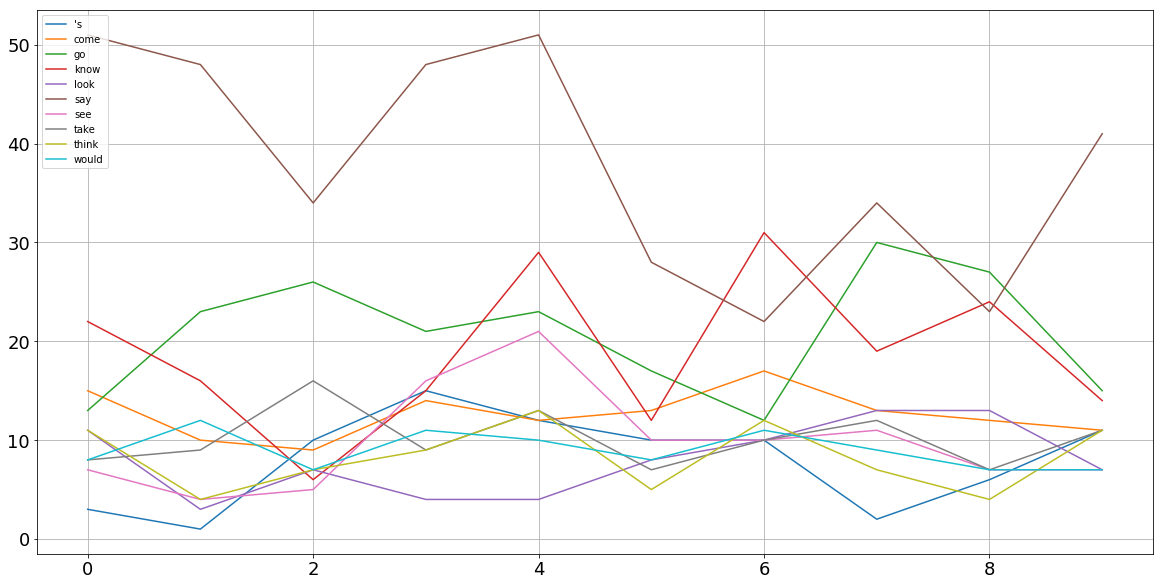

In [28]:
pd.DataFrame(list(parts_df["verb_dict_sep"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Seprated Version of Top 10 frequent nouns in the Progress of Text

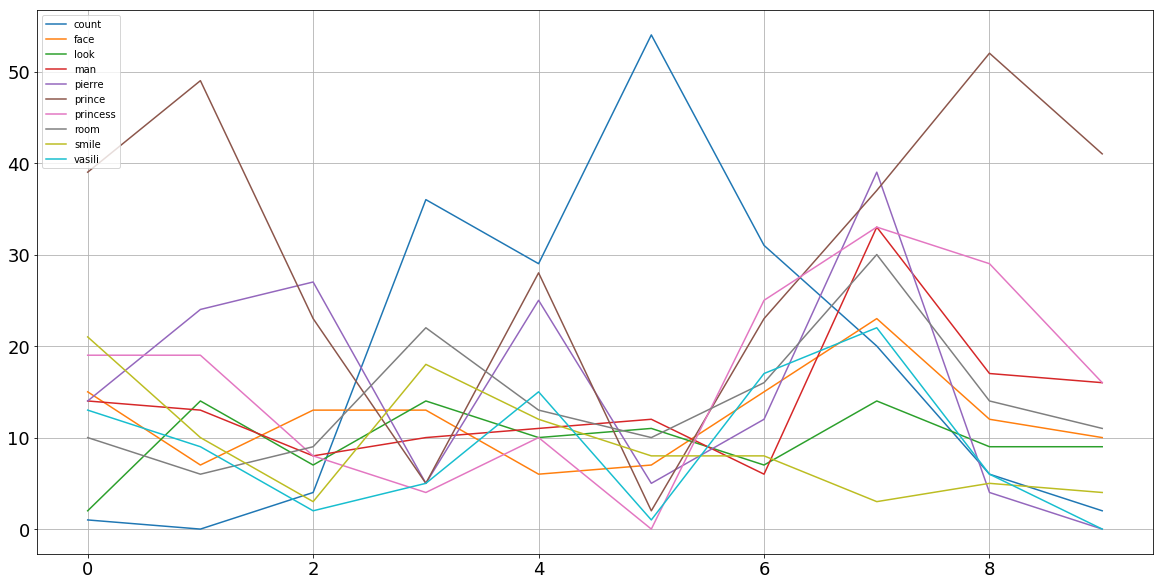

In [29]:
pd.DataFrame(list(parts_df["noun_dict_sep"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Seprated Version of Top 10 frequent adj in the Progress of Text

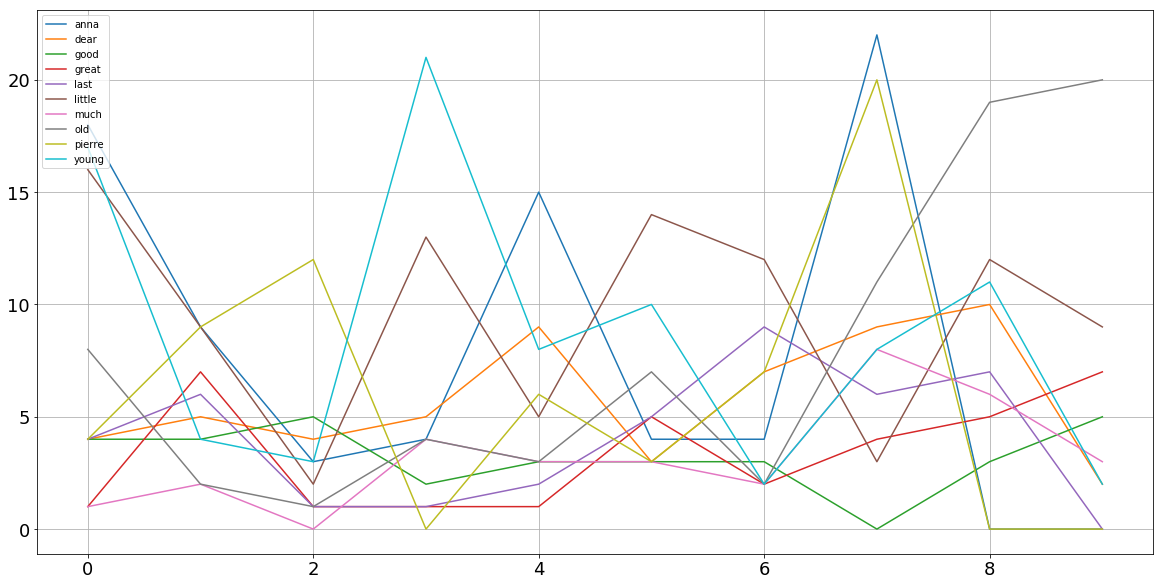

In [30]:
pd.DataFrame(list(parts_df["ADJ_dict_sep"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Accumulated Version of Top 10 frequent Verb in the Progress of Text

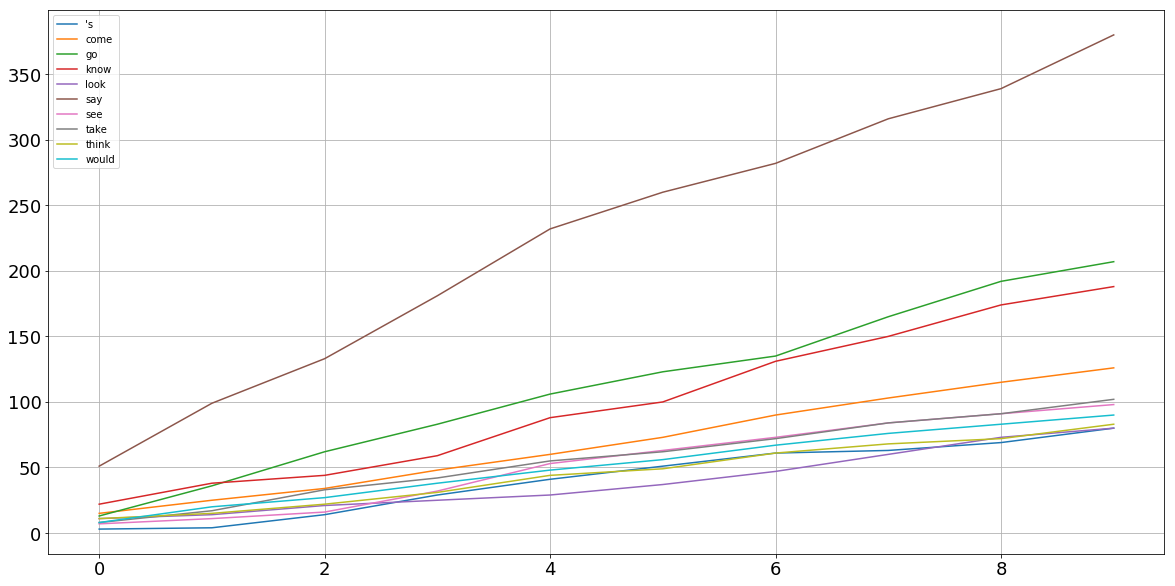

In [31]:
pd.DataFrame(list(parts_df["verb_dict"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Accumulated Version of Top 10 frequent Noun in the Progress of Text

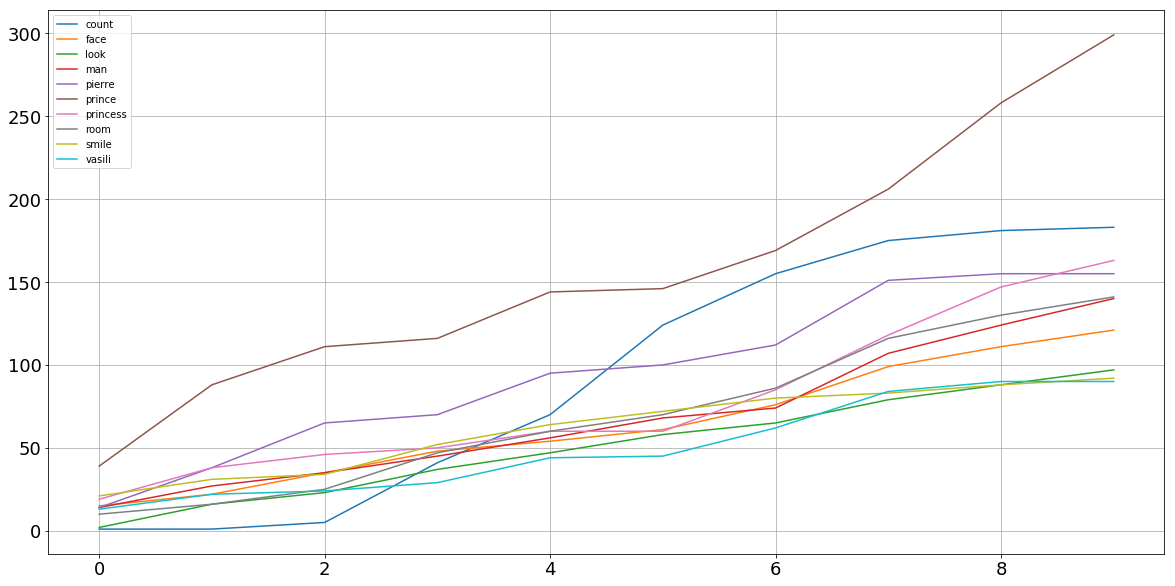

In [32]:
pd.DataFrame(list(parts_df["noun_dict"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Accumulated Version of Top 10 frequent Adj in the Progress of Text

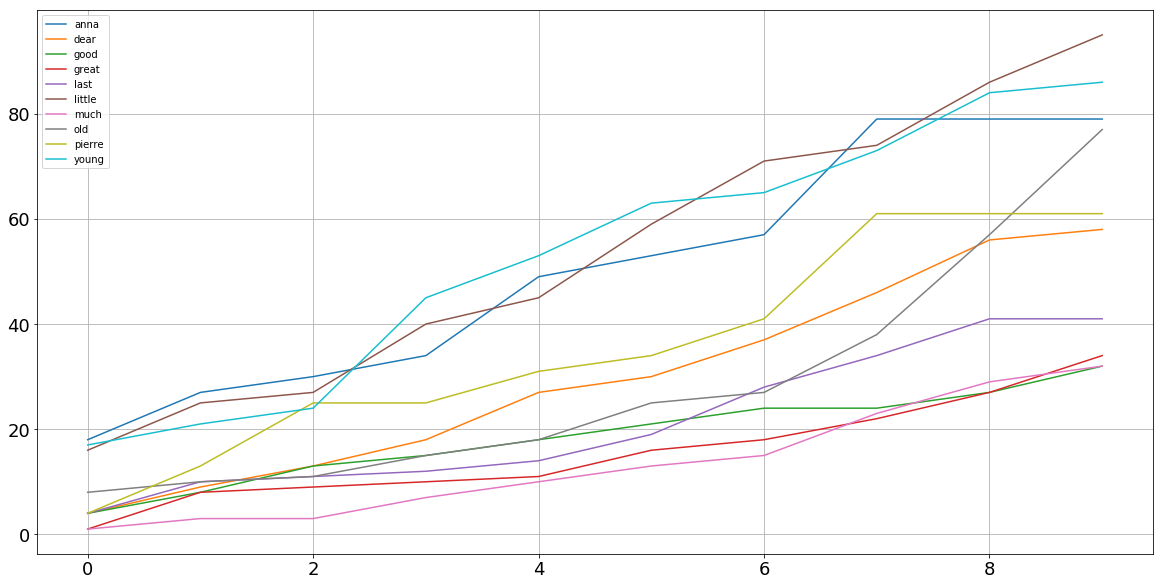

In [33]:
pd.DataFrame(list(parts_df["ADJ_dict"])).plot(figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

# Phrases Disturbution

In [34]:
text2,_=preprocess_wrapper(content, hiddesymbol=True, Puntuationfilter=True, stopworkfilter=True, stemfilter=False,
                       lemafilter=False, sent_token=False)

In [35]:
def ngram_gen(n,sent):
    ls_ngrams=[]
    sixgrams = ngrams(sent.split(), n)
    for grams in sixgrams:
          ls_ngrams.append(grams)
    return ls_ngrams

### find top 10  frequent bigrams

In [36]:
n_grams=ngram_gen(2,text2)
bigramdf=pd.DataFrame(list(Counter(n_grams).items()))
bigramdf.sort_values(1,ascending=False,inplace=True)
bigramdf.reset_index(drop=True,inplace=True)

In [37]:
bigramdf.head(10)

,0,1
0,"(prince, andrew)",99
1,"(anna, mikhaylovna)",91
2,"(prince, vasili)",84
3,"(anna, pavlovna)",59
4,"(said, prince)",45
5,"(drawing, room)",35
6,"(little, princess)",32
7,"(young, man)",31
8,"(old, man)",28
9,"(marya, dmitrievna)",27


### find top 10 frequent Tri-grams

In [38]:
n_grams=ngram_gen(3,text2)
trigramdf=pd.DataFrame(list(Counter(n_grams).items()))
trigramdf.sort_values(1,ascending=False,inplace=True)
trigramdf.reset_index(drop=True,inplace=True)

In [39]:
trigramdf.head(10)

,0,1
0,"(said, prince, andrew)",23
1,"(said, anna, pavlovna)",11
2,"(said, anna, mikhaylovna)",10
3,"(count, cyril, vladimirovich)",8
4,"(said, little, princess)",7
5,"(princess, anna, mikhaylovna)",7
6,"(said, prince, vasili)",7
7,"(said, prince, hippolyte)",5
8,"(continued, prince, andrew)",5
9,"(ah, dear, friend)",4


### Find top 10 rhetorical structure of trigrams

In [40]:
tokens=nltk.pos_tag(nltk.word_tokenize(text2)) 
tokens_tags=[tag for word, tag in tokens]

In [41]:
ls_ngrams=[]
n_grams = ngrams(tokens_tags, 3)
for grams in n_grams:
    ls_ngrams.append(grams)

In [42]:
trigramdf_phrase=pd.DataFrame(list(Counter(ls_ngrams).items()))
trigramdf_phrase.sort_values(1,ascending=False,inplace=True)
trigramdf_phrase.reset_index(drop=True,inplace=True)

In [43]:
trigramdf_phrase.columns=["POS_combination","Count"]

In [44]:
trigramdf_phrase.head(10)

,POS_combination,Count
0,"(NN, NN, NN)",918
1,"(JJ, NN, NN)",898
2,"(NN, NN, VBD)",650
3,"(NN, VBD, JJ)",617
4,"(JJ, NN, VBD)",533
5,"(VBD, JJ, NN)",499
6,"(NN, JJ, NN)",472
7,"(JJ, JJ, NN)",460
8,"(NN, VBD, NN)",378
9,"(NN, NN, JJ)",291


### Diagram of Number Occurence of thes Top 10 Structure in Progress of Text

In [45]:
list_combination=list(trigramdf_phrase.head(10)["POS_combination"])

In [46]:
list_combination

[('NN', 'NN', 'NN'),
 ('JJ', 'NN', 'NN'),
 ('NN', 'NN', 'VBD'),
 ('NN', 'VBD', 'JJ'),
 ('JJ', 'NN', 'VBD'),
 ('VBD', 'JJ', 'NN'),
 ('NN', 'JJ', 'NN'),
 ('JJ', 'JJ', 'NN'),
 ('NN', 'VBD', 'NN'),
 ('NN', 'NN', 'JJ')]

In [47]:
def find_combitaion_section(x):
    tokens=nltk.pos_tag(nltk.word_tokenize(x)) 
    tokens_tags=[tag for word, tag in tokens]
    ls_ngrams=[]
    n_grams = ngrams(tokens_tags, 3)
    for grams in n_grams:
        ls_ngrams.append(grams)
    trigramdf_phrase=pd.DataFrame(list(Counter(ls_ngrams).items()))
    trigramdf_phrase.sort_values(1,ascending=False,inplace=True)
    trigramdf_phrase.reset_index(drop=True,inplace=True)
    trigramdf_phrase.columns=["POS_combination","Count"]
    final_result={}
    for item in list_combination:
        if len(list(trigramdf_phrase[trigramdf_phrase["POS_combination"]==item]["Count"]))!=0:
            final_result[item]=list(trigramdf_phrase[trigramdf_phrase["POS_combination"]==item]["Count"])[0]
        else:
            final_result[item]=0
    return final_result

In [48]:
parts_df["trigram_combination"]=parts_df["sents_sep"].apply(find_combitaion_section)

In [49]:
tri_com_phrase_struct=pd.DataFrame(list(parts_df["trigram_combination"]))

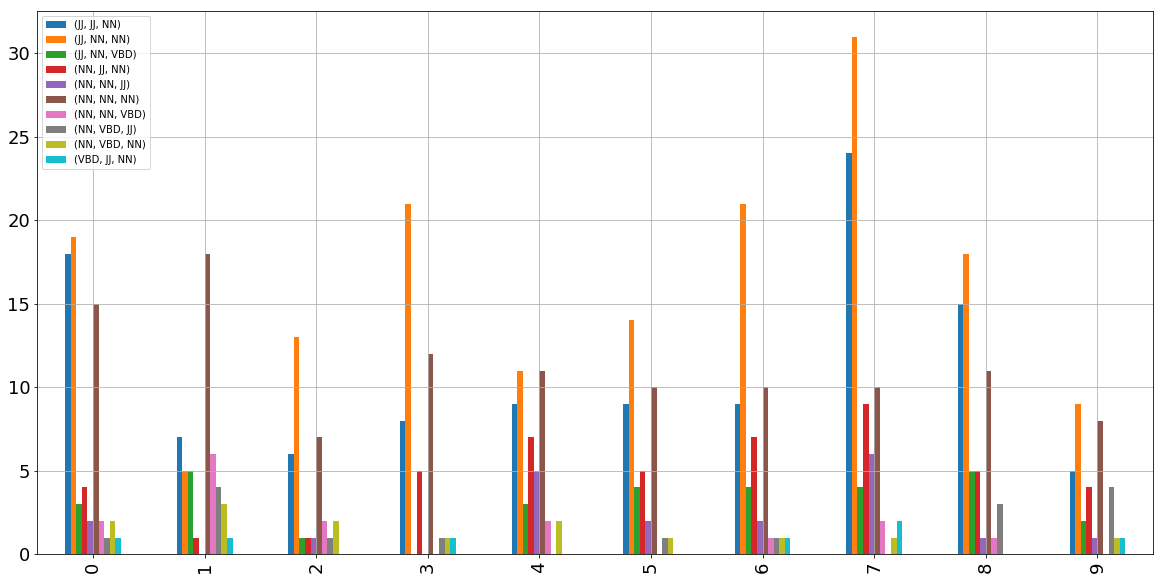

In [50]:
tri_com_phrase_struct.plot(kind="bar",figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')

### Diagram of Number Occurence of Top 10 More General Structure in Progress of Text

In [89]:
tokens=nltk.pos_tag(nltk.word_tokenize(text2)) 
tokens_tags=[tagmap[tag] for word, tag in tokens]
ls_ngrams=[]
n_grams = ngrams(tokens_tags, 3)
for grams in n_grams:
    ls_ngrams.append(grams)
trigramdf_phrase=pd.DataFrame(list(Counter(ls_ngrams).items()))
trigramdf_phrase.sort_values(1,ascending=False,inplace=True)
trigramdf_phrase.reset_index(drop=True,inplace=True)
trigramdf_phrase.columns=["POS_combination","Count"]
trigramdf_phrase.head(10)
list_combination1=list(trigramdf_phrase.head(10)["POS_combination"])

In [112]:
trigramdf_phrase

,POS_combination,Count
0,"(NOUN, NOUN, VERB)",1549
1,"(VERB, ADJ, NOUN)",1322
2,"(ADJ, NOUN, VERB)",1276
3,"(NOUN, VERB, ADJ)",1267
4,"(NOUN, NOUN, NOUN)",1262
5,"(NOUN, VERB, NOUN)",1246
6,"(ADJ, NOUN, NOUN)",1213
7,"(VERB, NOUN, NOUN)",902
8,"(VERB, NOUN, VERB)",840
9,"(NOUN, VERB, VERB)",772


In [94]:
def General_find_combitaion_section(x):
    tokens=nltk.pos_tag(nltk.word_tokenize(x)) 
    tokens_tags=[tagmap[tag] for word, tag in tokens]
    ls_ngrams=[]
    n_grams = ngrams(tokens_tags, 3)
    for grams in n_grams:
        ls_ngrams.append(grams)
    trigramdf_phrase=pd.DataFrame(list(Counter(ls_ngrams).items()))
    trigramdf_phrase.sort_values(1,ascending=False,inplace=True)
    trigramdf_phrase.reset_index(drop=True,inplace=True)
    trigramdf_phrase.columns=["POS_combination","Count"]
    final_result={}
    for item in list_combination1:
        if len(list(trigramdf_phrase[trigramdf_phrase["POS_combination"]==item]["Count"]))!=0:
            final_result[item]=list(trigramdf_phrase[trigramdf_phrase["POS_combination"]==item]["Count"])[0]
        else:
            final_result[item]=0
    return final_result

In [95]:
parts_df["trigram_combination"]=parts_df["sents_sep"].apply(General_find_combitaion_section)

In [96]:
tri_com_phrase_struct=pd.DataFrame(list(parts_df["trigram_combination"]))

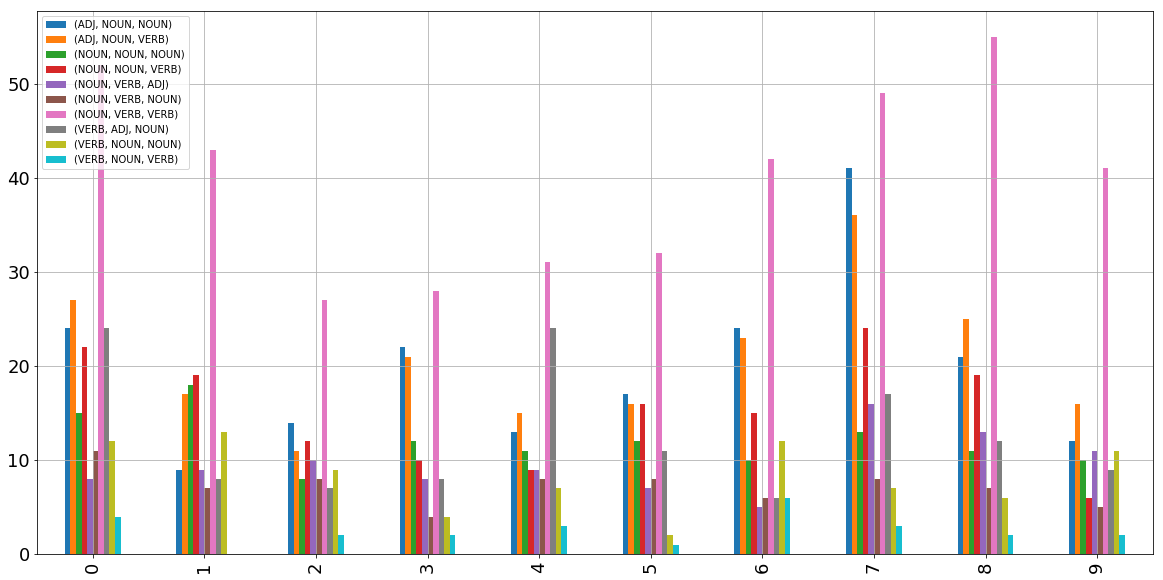

In [97]:
tri_com_phrase_struct.plot(kind="bar",figsize=(20,10),fontsize=18,grid=True).legend(loc='upper left')